In [1]:
# Uploading Data from Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [16]:
# Installing Libraries

!pip install easyocr
!pip install opencv-python-headless
!pip install pandas

  Obtaining dependency information for easyocr from https://files.pythonhosted.org/packages/cb/0e/09bafec31db720e796d3f5b0814c37c5fdb59dcd35a2c6c6b1c774b09646/easyocr-1.7.1-py3-none-any.whl.metadata
  Using cached easyocr-1.7.1-py3-none-any.whl.metadata (11 kB)
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/19/8e/24221589eb2dc066b14e29800d2e801c446f697c2d2240a9a61c6c0c5101/torch-2.4.0-cp310-cp310-win_amd64.whl.metadata
  Using cached torch-2.4.0-cp310-cp310-win_amd64.whl.metadata (27 kB)
  Obtaining dependency information for torchvision>=0.5 from https://files.pythonhosted.org/packages/e8/a3/4c868202fa23f69f9a58bb29ecbae5f9912c5d79fa5e78db5d3de7e6434f/torchvision-0.19.0-1-cp310-cp310-win_amd64.whl.metadata
  Using cached torchvision-0.19.0-1-cp310-cp310-win_amd64.whl.metadata (6.1 kB)
  Obtaining dependency information for opencv-python-headless from https://files.pythonhosted.org/packages/26/d0/22f68eb23eea053a31655960f133c0be9726c6a881547e6

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
# Packages

import pandas as pd
import numpy as np
import easyocr
import cv2
import matplotlib.pyplot as plt
import os

## ***Preprocessing and Data Exploration***

In [33]:
# Paths to the datasets on Google Drive

car_images_path = 'license_plates_detection_train'
car_annotations_path = 'Licplatesdetection_train.csv'
license_plate_images_path = 'license_plates_recognition_train'
license_plate_annotations_path = 'Licplatesrecognition_train.csv'
test_images_path = 'test'

In [20]:
# Load annotations
car_annotations = pd.read_csv(car_annotations_path)
license_plate_annotations = pd.read_csv(license_plate_annotations_path)

In [21]:
# Function to load and visualize images and annotations
def load_image(image_path):
    return cv2.imread(image_path)

def plot_image_with_bbox(image, bbox, title="Image with Bounding Box"):
    ymin, xmin, ymax, xmax = bbox
    # ymin, xmin, ymax, xmax = int(bbox[0]),int(bbox[1]),int(bbox[2]),int(bbox[3])
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

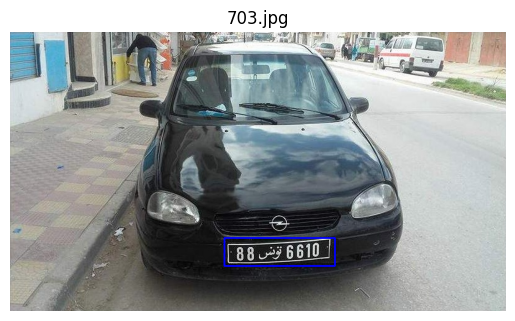

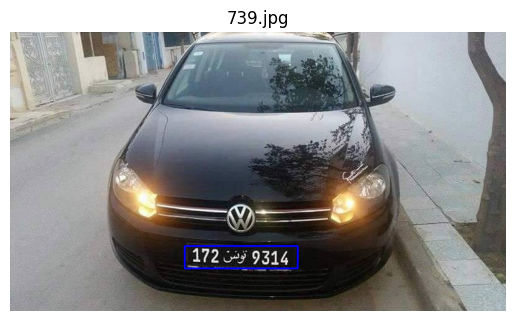

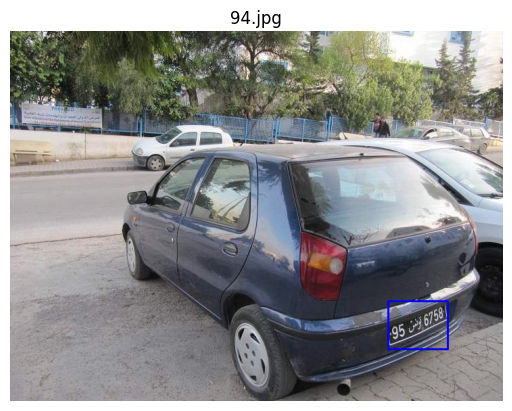

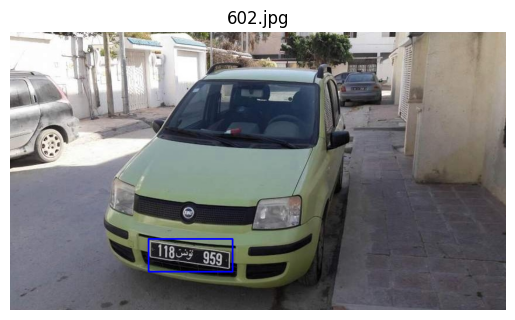

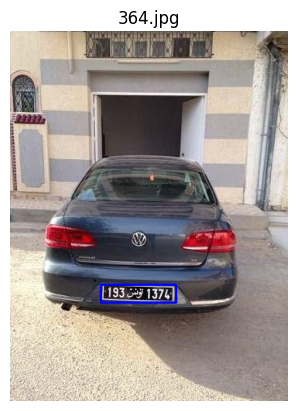

In [35]:
# Display some sample images with bounding boxes from Training Set 1
sample_images = car_annotations.sample(5)
for index, row in sample_images.iterrows():
    image_path = os.path.abspath(os.path.join(car_images_path, row['img_id']))
    if not os.path.exists(image_path):
        print("eeeeee")
    # print(image_path)
    image = load_image(image_path)
    if image is None:
        print("error")
        continue
    # print(image)
    bbox = [int(row['ymin']), int(row['xmin']), int(row['ymax']), int(row['xmax'])]
    # print(bbox)
    plot_image_with_bbox(image, bbox, title=row['img_id'])

In [36]:
# Explore the car annotations dataset
print("Car Annotations DataFrame:")
print(car_annotations.head())

Car Annotations DataFrame:
    img_id   ymin   xmin   ymax   xmax
0    1.jpg  276.0   94.0  326.0  169.0
1   10.jpg  311.0  395.0  344.0  444.0
2  100.jpg  406.0  263.0  450.0  434.0
3  101.jpg  283.0  363.0  315.0  494.0
4  102.jpg  139.0   42.0  280.0  222.0


In [37]:
# Check for any missing values in car annotations
print("\nMissing values in car annotations:")
print(car_annotations.isnull().sum())



Missing values in car annotations:
img_id    0
ymin      0
xmin      0
ymax      0
xmax      0
dtype: int64


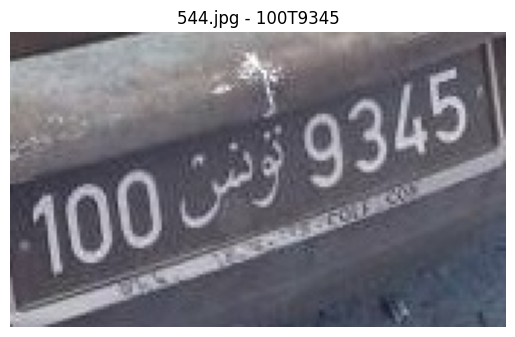

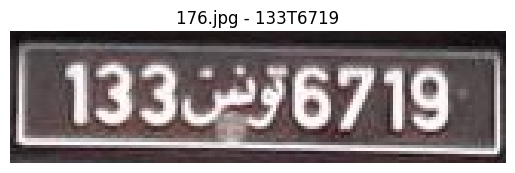

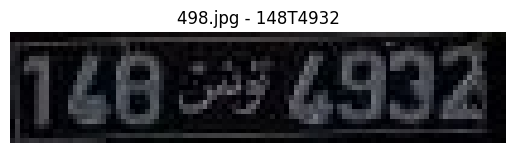

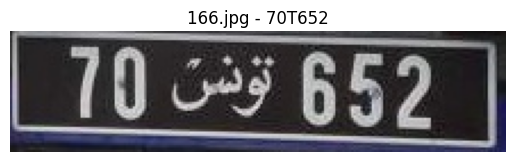

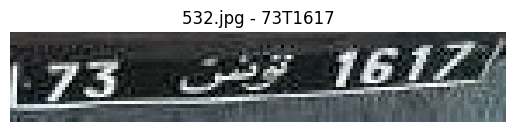

In [38]:
# Load and display some sample license plate images from Training Set 2
sample_license_plate_images = license_plate_annotations.sample(5)
for index, row in sample_license_plate_images.iterrows():
    image_path = os.path.join(license_plate_images_path, row['img_id'])
    image = load_image(image_path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"{row['img_id']} - {row['text']}")
    plt.axis('off')
    plt.show()

In [39]:
# Explore the license plate annotations dataset
print("License Plate Annotations DataFrame:")
print(license_plate_annotations.head())

License Plate Annotations DataFrame:
    img_id      text
0    0.jpg  117T3989
1    1.jpg  128T8086
2   10.jpg   94T3458
3  100.jpg  133T6719
4  101.jpg   68T5979


In [40]:
# Check for any missing values in license plate annotations
print("\nMissing values in license plate annotations:")
print(license_plate_annotations.isnull().sum())


Missing values in license plate annotations:
img_id    0
text      0
dtype: int64


## ***License Plate Detection***

In [41]:
# Libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

In [42]:
# simple CNN model for object detection
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    bbox_output = Dense(4, activation='linear')(x)
    model = Model(inputs, bbox_output)
    return model

input_shape = (224, 224, 3)
model = create_model(input_shape)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856 

## ***Character Recognition***

In [43]:
# Packages
import easyocr

In [71]:
# Function to perform OCR on license plate images
reader = easyocr.Reader(['en', 'ar'])

# Function to recognize characters in the image
def recognize_characters(image):
    if isinstance(image, str):  # Check if the input is a file path
        image1 = cv2.imread(image)  # Load the image using OpenCV if it's a file path
        # print(str(image1))
        if image1 is None:
            print("img could not be loaded")
    elif not isinstance(image, (np.ndarray, bytes)):  # Check if the input is a NumPy array or bytes
        # print("elif")
        raise ValueError('Invalid input type. Supporting format = string(file path or url), bytes, numpy array')

    result = reader.readtext(image1)
    print(result)
    recognized_text = ' '.join([text for _,text, _ in result])
    return recognized_text

# sample_image_filename = license_plate_annotations.iloc[0]['img_id'] + '.jpg'
sample_image_filename = license_plate_annotations.iloc[1]['img_id']
sample_image_path = os.path.join(license_plate_images_path, sample_image_filename)
print(sample_image_path)
if not os.path.exists(sample_image_path):
    print("no path")

# Recognize characters in the image
recognized_text = recognize_characters(sample_image_path)
print(f"Recognized Text: {recognized_text}")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


License_plates_recognition_train\1.jpg
[[[[0, 0], [130, 0], [130, 24], [0, 24]], '80867 تنن 728|', 0.3997987165548337]]
Recognized Text: 80867 تنن 728|
